In [1]:
import os
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from tqdm import tqdm
# Workaround
try:
    import ctypes
    libgcc_s = ctypes.CDLL('libgcc_s.so.1')
except:
    pass


from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args,
)  # noqa: E402

from guided_diffusion.script_util import (
    sr_model_and_diffusion_defaults,
    sr_create_model_and_diffusion,
)
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample

import torch
import torchvision.transforms as T

In [2]:
intermediate_steps = False #return intermediate results (usefull to create gifs, but will use lot of memory - around 3GB for one 256x256 image)
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2-attention.yml'))
print(conf.inpa_inj_sched_prev) #Are you about to use RePainting ?print(conf.diffusion_steps) #may not be the good one
conf.intermediate_steps = intermediate_steps
print(conf.intermediate_steps)


True
False


In [3]:
print("Start", conf['name'])

device = dist_util.dev(conf.get('device'))


model, diffusion = create_model_and_diffusion(
    **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)


Start my_conf


In [4]:
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()
model.to(device)
show_progress = conf.show_progress

import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Nombre de paramètres : ', params)

Nombre de paramètres :  552814086


In [5]:

cond_fn = None

def model_fn(x, t, y=None, gt=None, **kwargs):
    assert y is not None
    return model(x, t, y if conf.class_cond else None, gt=gt)

dset = 'eval'

eval_name = conf.get_default_eval_name()
dl = conf.get_dataloader(dset=dset, dsName=eval_name)


In [10]:
x = next(iter(dl))
img = x['GT'].to(device)
mask = x['gt_keep_mask'].to(device)

model_kwargs = {}
model_kwargs["gt"] = img
model_kwargs['y'] = '-1' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
model_kwargs['gt_keep_mask'] = mask
model_kwargs['stop_to'] = None
model_kwargs['starting_point'] = {'x':torch.randn(x['GT'].shape),'step':4310}

batch_size = model_kwargs['gt'].shape[0]
return_all = False
sample_fn = (
        diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
)

result = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=return_all,
    conf=conf
)


  0%|          | 0/260 [00:00<?, ?it/s]

In [37]:
input_b = [10,11,13,14,16,17]
mid_b = [0]
output_b = [0,1,2,3,4,5,6,7,8]
blocks = []
for i in input_b:
    blocks.append(model.input_blocks[i][1])
for i in mid_b:
    blocks.append(model.middle_block[1])
for i in output_b:
    blocks.append(model.output_blocks[i][1])

In [41]:
for i in blocks:
    print(i.c)
    print(i.dim)
    print(i.last_att.shape)

512
[32, 32]
torch.Size([1024, 1024])
512
[32, 32]
torch.Size([1024, 1024])
1024
[16, 16]
torch.Size([256, 256])
1024
[16, 16]
torch.Size([256, 256])
1024
[8, 8]
torch.Size([64, 64])
1024
[8, 8]
torch.Size([64, 64])
1024
[8, 8]
torch.Size([64, 64])
1024
[8, 8]
torch.Size([64, 64])
1024
[8, 8]
torch.Size([64, 64])
1024
[8, 8]
torch.Size([64, 64])
1024
[16, 16]
torch.Size([256, 256])
1024
[16, 16]
torch.Size([256, 256])
1024
[16, 16]
torch.Size([256, 256])
512
[32, 32]
torch.Size([1024, 1024])
512
[32, 32]
torch.Size([1024, 1024])
512
[32, 32]
torch.Size([1024, 1024])


In [119]:
from PIL import Image
from torchvision import transforms
img = transforms.ToTensor()(Image.open('log/face_example/gt/000000.png'))*255


In [114]:
def extract_important_patchs(att):
    tmp = torch.stack([torch.sum(att[:,j]) for j in range(len(att))]) #sum on column is how much a patch is important
    tmp = (tmp>torch.quantile(tmp.type(torch.float32),0.75)).int()
    most_importants = torch.nonzero(tmp).squeeze(dim=1)
    return(most_importants)

def visualize_att(img,patchs,patch_size):
    channels,img_size,_ = img.shape
    l = int(img_size/patch_size) #num patch per line
    num_patch = int(l**2)
    s = th.ones(channels,img_size,img_size)
    im_copy = th.clone(img)


    for i in range(num_patch):
        x1 = patch_size*(i%l)
        y1 = x1 + patch_size
        x2 = patch_size*(i//l)
        y2 = x2+patch_size

        if i in patchs: #if high att
            r,g,b = im_copy[:,x2:y2,x1:y1].unbind(dim=0)
            patch = th.stack([(210*th.ones(8,8)),0.75*g,0.75*b]) #torch.stack([((r+g+b)/3),(g/3),(b/3)])
            #print(patch == img[x2:y2,x1:y1,:])
            s[:,x2:y2,x1:y1] = patch
        else:
            s[:,x2:y2,x1:y1] = im_copy[:,x2:y2,x1:y1]

    return(s.type(th.uint8))



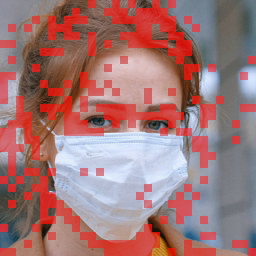

In [118]:
img_att = visualize_att(img,most_importants,8)
transforms.ToPILImage()(img_att) #not much attention on the mask)